# Sensitivity analysis of benchmark results

* input data ($P_{load}$ and $P_{sun}$)
* P_pv rated
* E_rated

Pierre Haessig, April 2018

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

### Load testcase data

In [2]:
E_rated = 10 # kWh
P_pvp = 3 # kW
P_grid_max = 3 # kW

In [262]:
df = pd.read_csv('../data/data_2011-2012.csv', index_col=0, parse_dates=True)

# slice test weeks
df = df['2011-11-29':'2011-12-05'] # 1 week
#df = df['2011-11-29':'2011-12-12'] # 2 weeks
#df = df['2011-11-29':'2011-12-19'] # 3 weeks
#df = df['2011-11-29':'2011-12-26'] # 4 weeks

n = len(df)
n

336

In [263]:
P_load = df.GC
P_sun = df.GG/1.04*P_pvp;

dt = 0.5 # hours
t = np.arange(n)*dt # hours
td = t/24 #days

In [264]:
print('Average sun energy: {:.2f} kWh/d'.format(P_sun.mean()*24))
print('Average load      : {:.2f} kWh/d'.format(P_load.mean()*24))
print('ratio sun/load: {:.2%}'.format(P_sun.mean()/P_load.mean()))

Average sun energy: 12.71 kWh/d
Average load      : 16.90 kWh/d
ratio sun/load: 75.22%


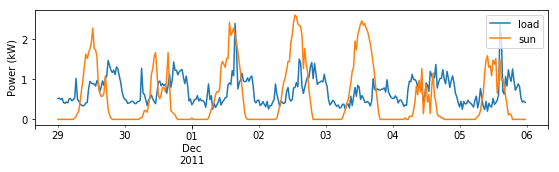

In [265]:
fig = plt.figure(figsize=(8,2.5))
P_load.plot(label='load')
P_sun.plot(label='sun')
plt.legend()
plt.ylabel('Power (kW)')
fig.tight_layout()

## Input data bootstrap

In [266]:
def dayblock_bootstrap(X, ns, blen=1, dlen=48):
    '''block bootstrap of vector timeseries X
    return `ns` samples.
    X is array of shape (n, nvars).
    blocks are made of `blen` contiguous days, starting at midnight 
    '''
    n = X.shape[0]
    assert n%dlen == 0, 'time series length should be a multiple of day length'
    ndays = n//dlen
    
    blen = blen*dlen # days -> samples
    
    # Augmented X, with beginning pasted at the end (circling indexing)
    Xaug = np.vstack([X, X[:blen, :]])
    
    # number of blocks needed
    nb = int(np.ceil(n/blen))
    
    print('bootstrapping {} samples out of {} possibilities'.format(ns, ndays ** nb))
    
    Xb_list = []
    
    for i in range(ns):
        # output, before cropping
        Xb = np.zeros((nb*blen, X.shape[1]))

        for k in range(nb):
            # random slice of length blen
            i0 = np.random.randint(0, ndays-1) * dlen
            Xk = Xaug[i0:i0+blen, :]
            # paste slice in output
            Xb[k*blen:(k+1)*blen, :] = Xk
        # output cropped to the size of X
        Xb_list.append(Xb[:n, :])
    return Xb_list

In [267]:
X = np.vstack([P_load, P_sun]).T
X.shape

(336, 2)

bootstrapping 300 samples out of 343 possibilities


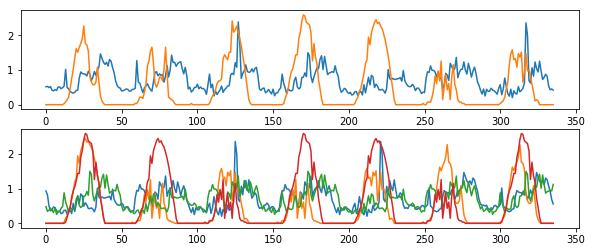

In [268]:
np.random.seed(0)

plt.figure(figsize=(10,4))
plt.subplot(211)

Xb_list = dayblock_bootstrap(X, 300, 3)
plt.plot(X)
plt.subplot(212)
i0 = i*dlen
plt.plot(Xb_list[0])
plt.plot(Xb_list[1])

Cumulated energy for each sample (for load and for sun)

In [269]:
X_cumen = np.zeros((len(Xb_list), 2))
for k, Xb in enumerate(Xb_list):
    X_cumen[k,:] = Xb.mean(axis=0)*24 # kWh/day

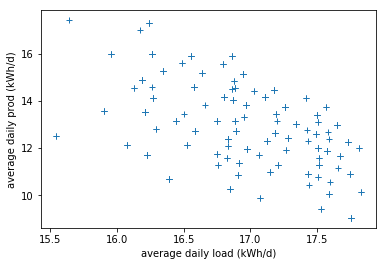

In [270]:
plt.plot(X_cumen[:,0], X_cumen[:,1], '+')
plt.xlabel('average daily load (kWh/d)');
plt.ylabel('average daily prod (kWh/d)');

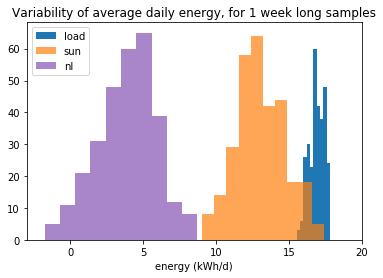

In [271]:
plt.title('Variability of average daily energy, for {} week long samples'.format(n//(48*7)))
plt.hist(X_cumen[:,0], label='load')
plt.hist(X_cumen[:,1], alpha=0.7, label='sun')
plt.hist(X_cumen[:,0] - X_cumen[:,1], color='tab:purple', alpha=0.8, label='nl')
plt.legend()
plt.xlabel('energy (kWh/d)')
plt.xlim(-3, 20);
plt.savefig('var_daily_ener_w{}.png'.format(n//(48*7)), dpi=150)

In [183]:
X_cumen.mean(axis=0)

array([16.93146238, 13.03044368])

In [184]:
X_cumen.std(axis=0)

array([0.50617683, 1.67681317])

In [185]:
X_cumen.std(axis=0)

array([0.50617683, 1.67681317])

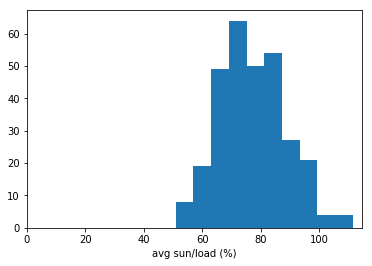

In [192]:
plt.hist(X_cumen[:,1]/X_cumen[:,0]*100);
plt.xlim(xmin=0)
plt.xlabel('avg sun/load (%)');

## Solar home simulation

using rule-based control, taken from [solar_home_rule-based-control.ipynb](../methods/python_rule-based/solar_home_rule-based-control.ipynb))

control strategy: battery should absorb absorb net production, as long as feasible:

$$P_{sto} = -P_{nl} = P_{sun} - P_{load}$$

In [9]:
def control(P_sun, P_load, E_sto):
    P_nl = P_load - P_sun
    # outputs:
    P_sto = 0
    P_grid = 0
    P_curt = 0
    
    E_next = E_sto - P_nl*dt
    
    if P_nl>0: # (load > sun)
        E_next = E_next if E_next>0. else 0.
        P_sto = (E_next - E_sto)/dt # <0
        P_grid = P_nl + P_sto
    else:
        E_next = E_next if E_next<E_rated else E_rated
        P_sto = (E_next - E_sto)/dt # >0
        P_curt = -P_nl - P_sto
    return P_sto, P_grid, P_curt

In [148]:
def home_sim(E_rated, P_pvp, )
# to be continued

P_sto = np.zeros(n)
E_sto = np.zeros(n+1)
P_grid = np.zeros(n)
P_curt = np.zeros(n)

E_sto[0]= E_rated/2

for k in range(n):
    P_sto[k], P_grid[k], P_curt[k] = control(P_sun[k], P_load[k], E_sto[k])
    E_sto[k+1] = E_sto[k] + P_sto[k]*dt
    assert 0 <= E_sto[k+1] <= E_rated

    
E_sto = E_sto[:-1]
P_pv = P_sun - P_curt
P_nl = P_load - P_sun

In [149]:
print('E_load: {:6.2f} kWh/d (data)'.format(P_load.mean()*24))
print('E_sun:  {:6.2f} kWh/d (data)'.format(P_sun.mean()*24))
print('E_pv:   {:6.2f} kWh/d'.format(P_pv.mean()*24))
print('E_curt: {:6.2f} kWh/d'.format(P_curt.mean()*24))
print('E_grid: {:6.2f} kWh/d'.format(P_grid.mean()*24))

E_load:  16.90 kWh/d (data)
E_sun:   12.71 kWh/d (data)
E_pv:    12.40 kWh/d
E_curt:   0.31 kWh/d
E_grid:   3.78 kWh/d


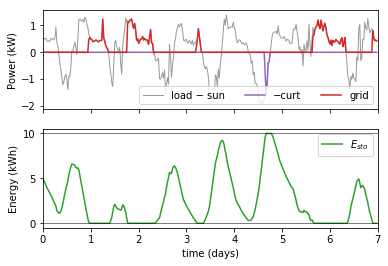

In [150]:
fig, ax = plt.subplots(2,1, sharex=True)

ax[0].plot(td, P_nl, label='load − sun',
           color=(0.6,)*3, lw=1)

ax[0].plot(td, -P_curt, label='−curt',
           color='tab:purple')

ax[0].plot(td, P_grid, label='grid',
           color='tab:red')

ax[0].legend(ncol=4)
ax[0].set(
    ylabel='Power (kW)'
)

ax[1].plot(td, E_sto, label='$E_{sto}$',
           color='tab:green');
ax[1].axhline(0, color='k', lw=0.5)
ax[1].axhline(E_rated, color='k', lw=0.5)

ax[1].legend()
ax[1].set(
    xlabel='time (days)',
    ylabel='Energy (kWh)',
    ylim=(-.05*E_rated, 1.05*E_rated),
    xlim=(0, n//48)
);